In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates a comparison of vehicle times from AVL data to the
scheduled arrival time at one stop for one example trip.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/saf537/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

### Data loading and such.

In [2]:
data = pd.read_csv('longjsons_parsed.csv')

### Selecting a sample trip

In [3]:
qstr = ('Trip == "MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16"')
bustime = data.query(qstr)
bustime.drop_duplicates(['vehicleID','RecordedAtTime'],inplace=True)
bustime.set_index(['Line','Trip','TripDate','vehicleID','RecordedAtTime'],
                  inplace=True,drop=True,verify_integrity=True)
# for now, use a truncated data set.  just get data for one line (M5).
tripDateLookup = "2016-05-25"
lineLookup = "MTA NYCT_B41"
avl_long = bustime.xs((lineLookup,tripDateLookup),level=(0,2))
del bustime,data # to free up memory

/opt/rh/anaconda/root/lib/python2.7/site-packages/pandas/util/decorators.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


This will be one example of one route

In [4]:
avl_data = avl_long
avl_data.head()

Latitude  \
Trip                                      vehicleID     RecordedAtTime                             
MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16 MTA NYCT_4587 2016-05-25T07:26:40.000-04:00  40.682170   
                                                        2016-05-25T07:27:11.000-04:00  40.681098   
                                                        2016-05-25T07:27:42.000-04:00  40.681126   
                                                        2016-05-25T07:28:14.000-04:00  40.680564   
                                                        2016-05-25T07:28:45.000-04:00  40.678978   

                                                                                       Longitude  \
Trip                                      vehicleID     RecordedAtTime                             
MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16 MTA NYCT_4587 2016-05-25T07:26:40.000-04:00 -73.976072   
                                                        2016-05-25T07:27:11.000-04:00 -73.975304   
                                                        2016-05-25T07:27:42.000-04:00 -73.975324   
                                                        2016-05-25T07:28:14.000-04:00 -73.974913   
                                                        2016-05-25T07:28:45.000-04:00 -73.973757   

                                                                                       TripPattern  \
Trip                                      vehicleID     RecordedAtTime                               
MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16 MTA NYCT_4587 2016-05-25T07:26:40.000-04:00  MTA_B410332   
                                                        2016-05-25T07:27:11.000-04:00  MTA_B410332   
                                                        2016-05-25T07:27:42.000-04:00  MTA_B410332   
                                                        2016-05-25T07:28:14.000-04:00  MTA_B410332   
                                                        2016-05-25T07:28:45.000-04:00  MTA_B410332   

                                                                                      MonitoredCallRef  \
Trip                                      vehicleID     RecordedAtTime                                   
MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16 MTA NYCT_4587 2016-05-25T07:26:40.000-04:00       MTA_901500   
                                                        2016-05-25T07:27:11.000-04:00       MTA_303297   
                                                        2016-05-25T07:27:42.000-04:00       MTA_303297   
                                                        2016-05-25T07:28:14.000-04:00       MTA_303297   
                                                        2016-05-25T07:28:45.000-04:00       MTA_303300   

                                                                                                      EstCallArrival  \
Trip                                      vehicleID     RecordedAtTime                                                 
MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16 MTA NYCT_4587 2016-05-25T07:26:40.000-04:00  2016-05-25T07:27:13.126-04:00   
                                                        2016-05-25T07:27:11.000-04:00  2016-05-25T07:27:43.111-04:00   
                                                        2016-05-25T07:27:42.000-04:00  2016-05-25T07:28:13.158-04:00   
                                                        2016-05-25T07:28:14.000-04:00  2016-05-25T07:28:43.133-04:00   
                                                        2016-05-25T07:28:45.000-04:00  2016-05-25T07:29:38.356-04:00   

                                                                                       DistFromCall  \
Trip                                      vehicleID     RecordedAtTime                                
MTA NYCT_FB_B6-Weekday-SDon-043400_B41_16 MTA NYCT_4587 2016-05-25T07:26:40.000-04:00          0.00   
                                                        2016-05-25T07:27:11.00

### Calculate the distance along the route of *each* of the AVL points and standardize the time recordings.

In [19]:
#n = len(avl_data.index)
pattern = '%Y-%m-%dT%H:%M:%S'
inter_stops = pd.DataFrame([],columns = ["DistAlongRoute","TimeStamp"])
inter_stops['DistAlongRoute'] = avl_data.CallDistAlongRoute - avl_data.DistFromCall
inter_stops['TimeStamp'] = avl_data.index.get_level_values('RecordedAtTime')
inter_stops['TimeStamp'] = inter_stops['TimeStamp'].apply(lambda x: int(time.mktime(time.strptime(x[:-10], pattern))))
inter_stops = inter_stops.reset_index()

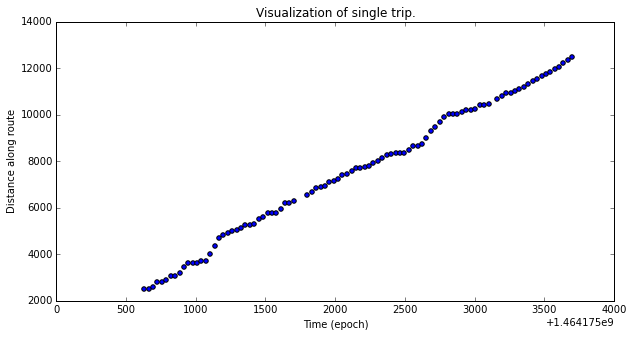

In [20]:
plt.figure(figsize=(10,5))
plt.scatter(inter_stops.TimeStamp,inter_stops.DistAlongRoute)
plt.title('Visualization of single trip.')
plt.xlabel('Time (epoch)')
plt.ylabel('Distance along route')

### Infer the time at each station from the time and distance recorded at the AVL calls

In [21]:
# List of stops
trip_id = "FB_B6-Weekday-SDon-043400_B41_16"
pattern = '%Y-%m-%dT%H:%M:%S'
stops_ex = list(pd.unique(avl_data.MonitoredCallRef))
distance_stops = list(pd.unique(avl_data.CallDistAlongRoute))
stops_route = pd.DataFrame([stops_ex,distance_stops])
stops_route = stops_route.T
stops_route.columns=['MonitoredCallRef','CallDistAlongRoute']

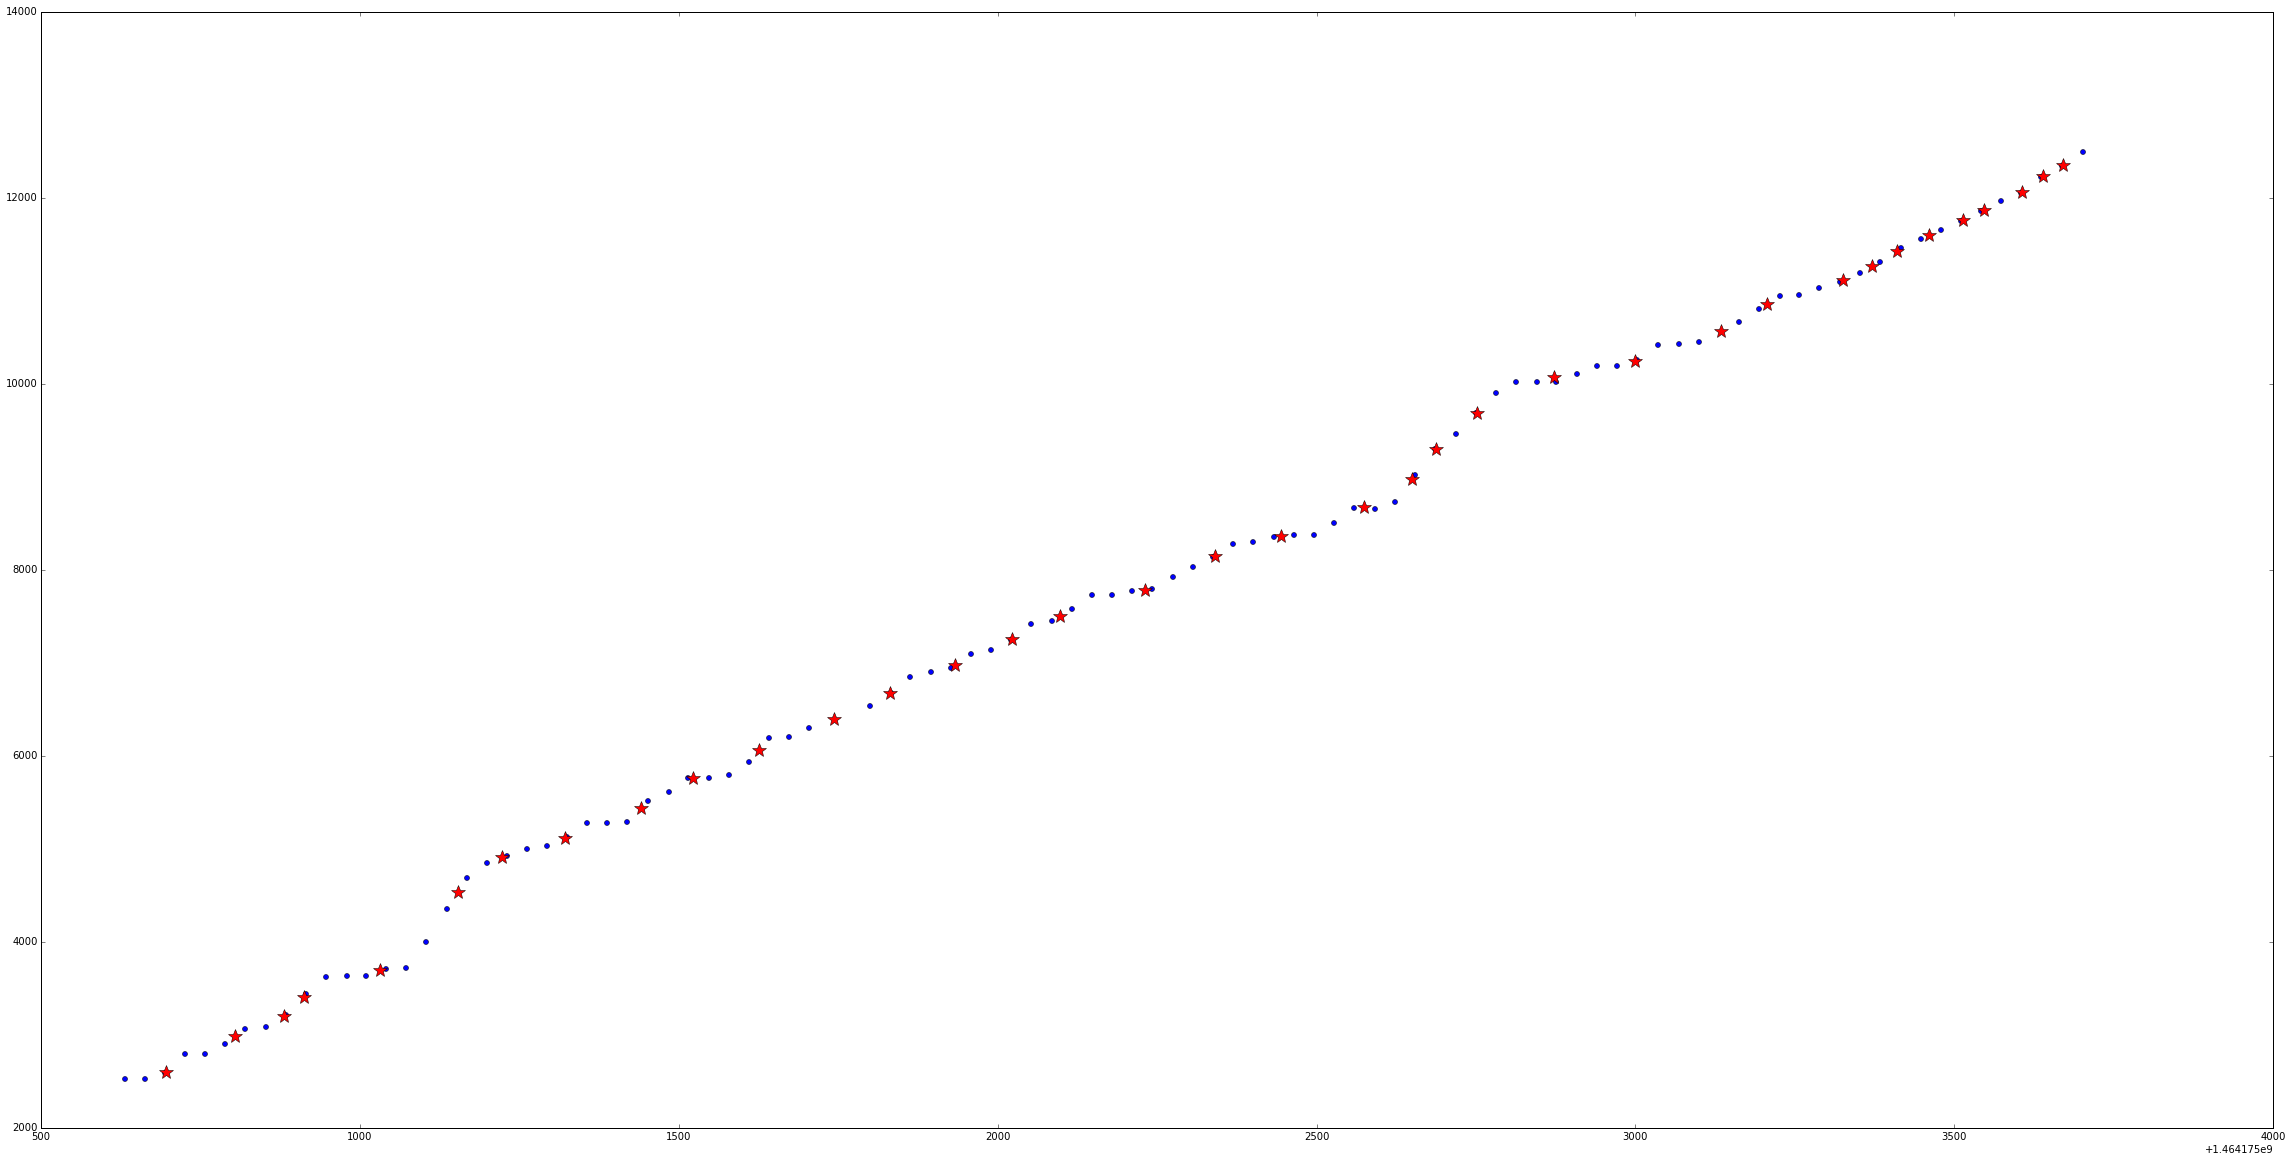

In [22]:
x = inter_stops.DistAlongRoute
y = inter_stops.TimeStamp
f = interpolate.interp1d(x,y)
xnew = distance_stops
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.figure(figsize=(40,20))
plt.plot(y,x, 'o',color='blue',markersize=5)
plt.plot(ynew, xnew, '*',color='red',markersize=15)

In [ ]:
# Cleaning up the head and tail of each trip

In [18]:
first = stops_ex[0]
last = stops_ex[-1]
last_set = avl_data[avl_data.MonitoredCallRef==last][['DistFromCall','PresentableDistance']]
first_set = avl_data[avl_data.MonitoredCallRef==first][['DistFromCall','PresentableDistance']]
avl_data = avl_data[avl_data.MonitoredCallRef!=last][avl_data.MonitoredCallRef!=first]

/opt/rh/anaconda/root/lib/python2.7/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [5]:
trip_id = "FB_B6-Weekday-SDon-043400_B41_16"

def interpolate_stops(avl_data,trip_id):
    stops_ex = list(pd.unique(avl_data.MonitoredCallRef))
    first = stops_ex[0]
    last = stops_ex[-1]
    last_set = avl_data[avl_data.MonitoredCallRef==last][['DistFromCall','PresentableDistance']]
    first_set = avl_data[avl_data.MonitoredCallRef==first][['DistFromCall','PresentableDistance']]
    avl_data = avl_data[avl_data.MonitoredCallRef!=last][avl_data.MonitoredCallRef!=first]
    distance_stops = list(pd.unique(avl_data.CallDistAlongRoute))
    stops_route = pd.DataFrame([stops_ex,distance_stops])
    stops_route = stops_route.T
    stops_route.columns=['MonitoredCallRef','CallDistAlongRoute']
    pattern = '%Y-%m-%dT%H:%M:%S'
    inter_stops = pd.DataFrame([],columns = ["DistAlongRoute","TimeStamp"])
    inter_stops['DistAlongRoute'] = avl_data.CallDistAlongRoute - avl_data.DistFromCall
    inter_stops['TimeStamp'] = avl_data.index.get_level_values('RecordedAtTime')
    inter_stops['TimeStamp'] = inter_stops['TimeStamp'].apply(lambda x: int(time.mktime(time.strptime(x[:-10], pattern))))
    inter_stops = inter_stops.reset_index()
    plt.figure(figsize=(10,5))
    plt.scatter(inter_stops.TimeStamp,inter_stops.DistAlongRoute)
    plt.title('Visualization of single trip.')
    plt.xlabel('Time (epoch)')
    plt.ylabel('Distance along route')
    x = inter_stops.DistAlongRoute
    y = inter_stops.TimeStamp
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    ynew = f(xnew)   # use interpolation function returned by `interp1d`
    plt.figure(figsize=(40,20))
    plt.plot(y,x, 'o',color='blue',markersize=5)
    plt.plot(ynew, xnew, '*',color='red',markersize=15)

/opt/rh/anaconda/root/lib/python2.7/site-packages/pandas/core/frame.py:1819: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)
/opt/rh/anaconda/root/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


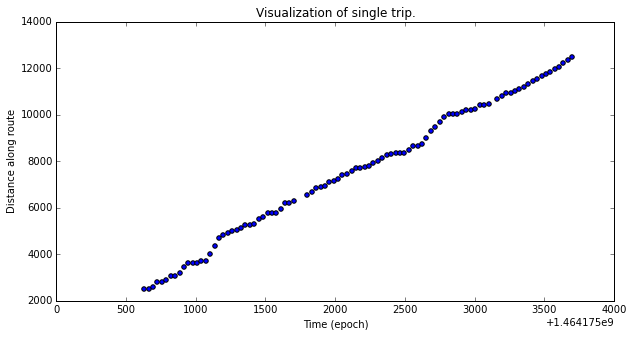

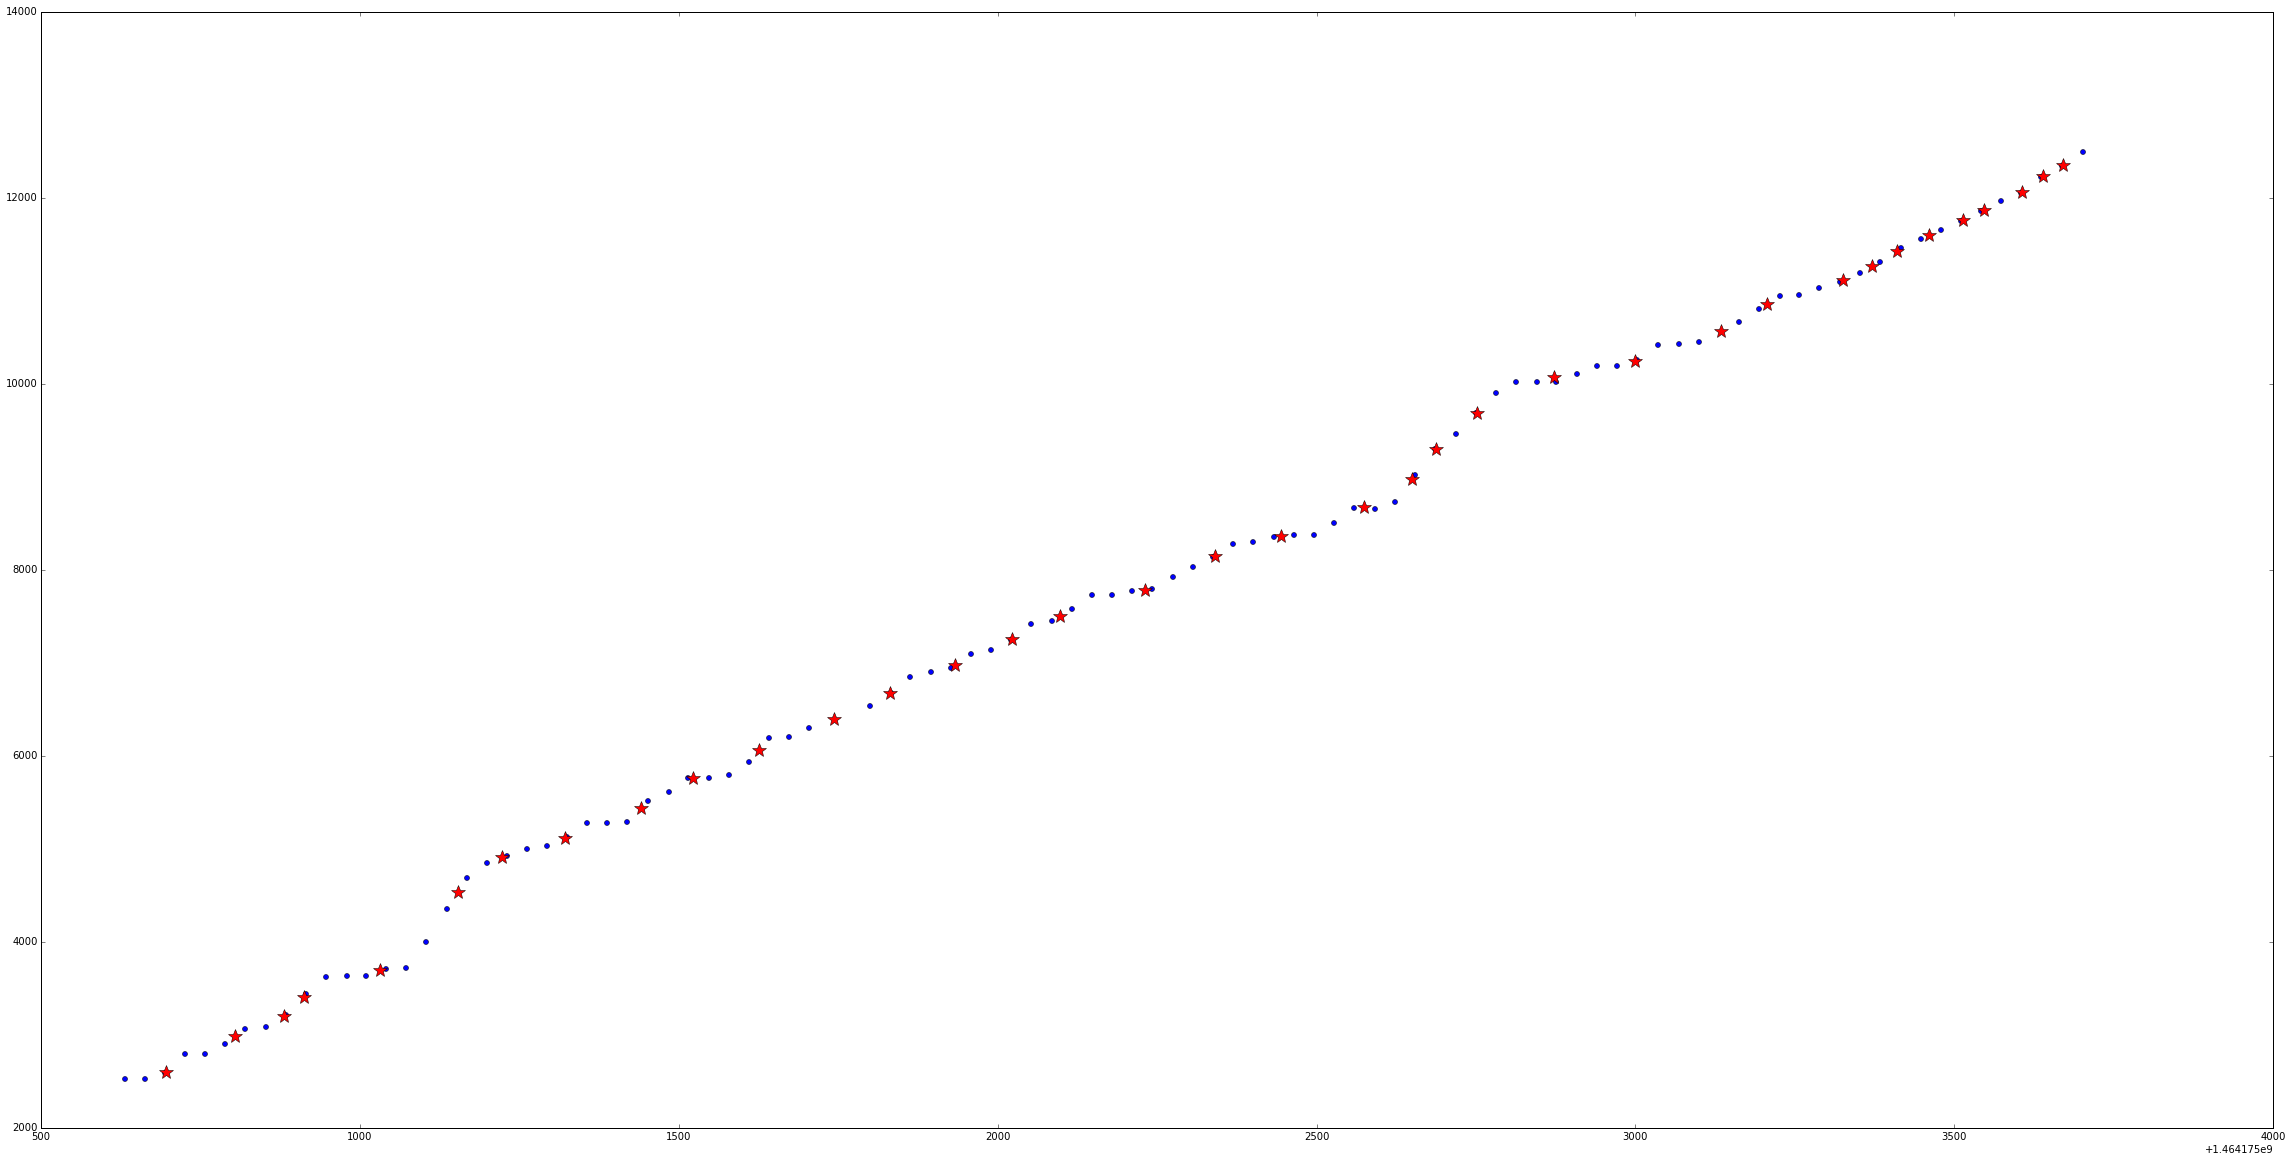

In [6]:
interpolate_stops(avl_data,trip_id)